In [15]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [27]:
MAX_WORDS = 15000
MAX_LEN = 120
TEST_SIZE = 0.20
RANDOM_STATE = 42
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Data preprocessing
def clean_text(text):
    if pd.isna(text):
        return ""
    return re.sub(r'[^a-zA-Z\s]', '', text.lower())

def load_and_preprocess_data():
    df = pd.read_csv("ReviewTokoBaju.csv")
    df = df.dropna(subset=['Review Text', 'Rating']).copy()
    df['Review Text'] = df['Review Text'].apply(clean_text)
    df['Rating'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

    # Balance the dataset
    count_0 = len(df[df['Rating']==0])
    count_1 = len(df[df['Rating']==1])

    if count_0 < count_1:
        df_min = df[df['Rating']==0]
        df_over = df_min.sample(count_1, replace=True, random_state=RANDOM_STATE)
        df = pd.concat([df[df['Rating']==1], df_over])
    else:
        df_min = df[df['Rating']==1]
        df_over = df_min.sample(count_0, replace=True, random_state=RANDOM_STATE)
        df = pd.concat([df[df['Rating']==0], df_over])

    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    return df

In [29]:
# Tokenizer implementation
class SimpleTokenizer:
    def __init__(self, num_words=MAX_WORDS, oov_token=''):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}
        self.word_counts = {}
        self.oov_token = oov_token

    def fit_on_texts(self, texts):
        all_words = []
        for text in texts:
            words = text.split()
            for word in words:
                if word in self.word_counts:
                    self.word_counts[word] += 1
                else:
                    self.word_counts[word] = 1

        # Sort by frequency and get top words
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        sorted_words = sorted_words[:self.num_words-1]  # -1 for OOV token

        # Create word index (starting from 1, as 0 is padding)
        self.word_index = {word[0]: idx+1 for idx, word in enumerate(sorted_words)}
        # Add OOV token
        if self.oov_token:
            self.word_index[self.oov_token] = len(self.word_index) + 1

        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = text.split()
            seq = []
            for word in words:
                if word in self.word_index:
                    seq.append(self.word_index[word])
                elif self.oov_token:
                    seq.append(self.word_index[self.oov_token])
            sequences.append(seq)
        return sequences

In [30]:
def pad_sequences(sequences, maxlen=MAX_LEN):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            padded_sequences.append(seq[:maxlen])
        else:
            padded_sequences.append([0] * (maxlen - len(seq)) + seq)
    return padded_sequences

In [31]:
# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [32]:
# BiRNN model with attention
class BiRNNAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=64, hidden_dim_2=32, output_dim=1):
        super(BiRNNAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.4)
        self.gru2 = nn.GRU(hidden_dim*2, hidden_dim_2, bidirectional=True, batch_first=True, dropout=0.3)

        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim_2*2, num_heads=4, batch_first=True)

        self.fc = nn.Linear(hidden_dim_2*2, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(64, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]

        output1, _ = self.gru1(embedded)
        # output1 = [batch size, sent len, hid dim * 2]

        output2, _ = self.gru2(output1)
        # output2 = [batch size, sent len, hid dim_2 * 2]

        # Apply self-attention
        attn_output, _ = self.attention(output2, output2, output2)
        # attn_output = [batch size, sent len, hid dim_2 * 2]

        # Global average pooling
        avg_pool = torch.mean(attn_output, dim=1)
        # avg_pool = [batch size, hid dim_2 * 2]

        dense = self.fc(avg_pool)
        dense = torch.relu(dense)
        dense = self.dropout(dense)

        output = self.fc_out(dense)
        return torch.sigmoid(output)

In [33]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [34]:
# Training function
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    early_stopping = EarlyStopping(patience=4)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_idx, (text, labels) in enumerate(train_loader):
            text, labels = text.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predicted = (predictions > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(DEVICE), labels.to(DEVICE)
                predictions = model(text).squeeze(1)
                loss = criterion(predictions, labels)

                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += ((predictions > 0.5).float() == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(early_stopping.best_model)
            break

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }

    return model, history

In [35]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for text, labels in test_loader:
            text = text.to(DEVICE)
            predictions = model(text).squeeze(1).cpu().numpy()
            y_prob.extend(predictions)
            y_pred.extend((predictions > 0.5).astype(int))
            y_true.extend(labels.numpy())

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall: {rec:.4f}")
    print(f"Test F1: {f1:.4f}")
    print(f"Test AUC: {auc_score:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    return acc, prec, rec, f1, auc_score, fpr, tpr

In [36]:
# Plotting functions
def plot_training(history):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('BiRNN Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('BiRNN Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def plot_roc(fpr, tpr, auc):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'BiRNN (AUC = {auc:.4f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

Using device: cuda
Dataset shape after preprocessing: (34896, 11)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(



=== Training BiRNN model ===
Epoch: 1/10 | Batch: 0/186 | Loss: 0.6966
Epoch: 1/10 | Batch: 10/186 | Loss: 0.6851
Epoch: 1/10 | Batch: 20/186 | Loss: 0.6849
Epoch: 1/10 | Batch: 30/186 | Loss: 0.6311
Epoch: 1/10 | Batch: 40/186 | Loss: 0.4747
Epoch: 1/10 | Batch: 50/186 | Loss: 0.4398
Epoch: 1/10 | Batch: 60/186 | Loss: 0.4785
Epoch: 1/10 | Batch: 70/186 | Loss: 0.4209
Epoch: 1/10 | Batch: 80/186 | Loss: 0.3951
Epoch: 1/10 | Batch: 90/186 | Loss: 0.3884
Epoch: 1/10 | Batch: 100/186 | Loss: 0.2710
Epoch: 1/10 | Batch: 110/186 | Loss: 0.3286
Epoch: 1/10 | Batch: 120/186 | Loss: 0.3837
Epoch: 1/10 | Batch: 130/186 | Loss: 0.4470
Epoch: 1/10 | Batch: 140/186 | Loss: 0.3375
Epoch: 1/10 | Batch: 150/186 | Loss: 0.3278
Epoch: 1/10 | Batch: 160/186 | Loss: 0.3449
Epoch: 1/10 | Batch: 170/186 | Loss: 0.2503
Epoch: 1/10 | Batch: 180/186 | Loss: 0.2196
Epoch: 1/10 | Train Loss: 0.4326 | Train Acc: 0.7927 | Val Loss: 0.3028 | Val Acc: 0.8789
Epoch: 2/10 | Batch: 0/186 | Loss: 0.2557
Epoch: 2/10 |

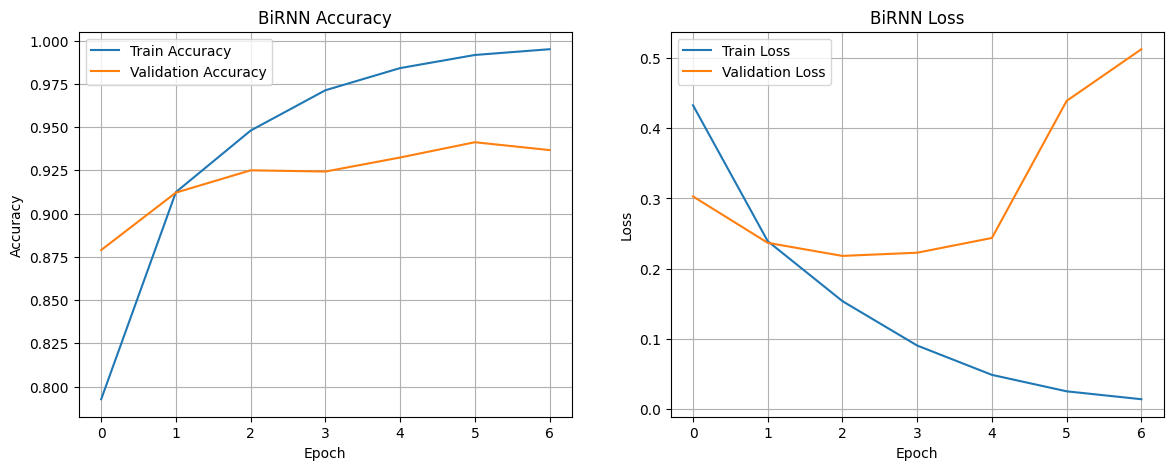

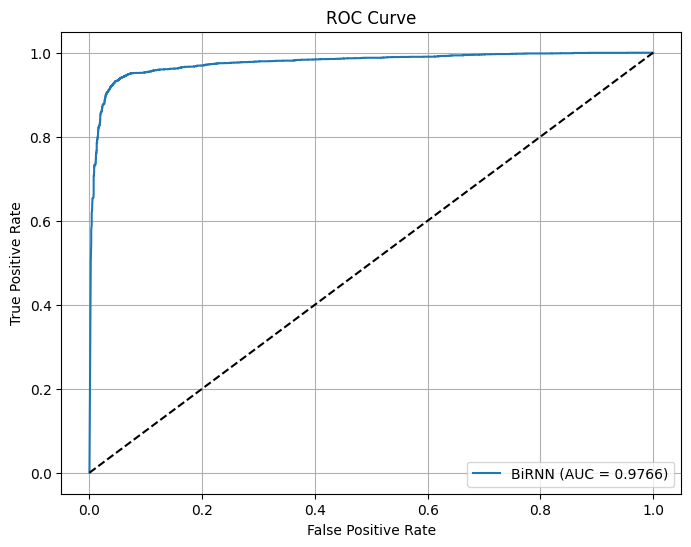


Model saved successfully.


In [37]:
def main():
    print(f"Using device: {DEVICE}")

    # Load and preprocess data
    df = load_and_preprocess_data()
    print(f"Dataset shape after preprocessing: {df.shape}")

    # Split data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        df['Review Text'].values,
        df['Rating'].values,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=df['Rating'].values
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.15,
        random_state=RANDOM_STATE,
        stratify=y_train_val
    )

    # Tokenize and pad sequences
    tokenizer = SimpleTokenizer(num_words=MAX_WORDS, oov_token='')
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

    # Create datasets and dataloaders
    train_dataset = TextDataset(X_train_pad, y_train)
    val_dataset = TextDataset(X_val_pad, y_val)
    test_dataset = TextDataset(X_test_pad, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Initialize BiRNN model
    vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
    birnn_model = BiRNNAttention(vocab_size, EMBEDDING_DIM).to(DEVICE)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(birnn_model.parameters(), lr=LEARNING_RATE)

    # Train model
    print("\n=== Training BiRNN model ===")
    birnn_model, history = train(birnn_model, train_loader, val_loader, optimizer, criterion, EPOCHS)

    # Evaluate model
    print("\n=== Evaluating BiRNN model ===")
    acc, prec, rec, f1, auc, fpr, tpr = evaluate_model(birnn_model, test_loader)

    # Plot results
    plot_training(history)
    plot_roc(fpr, tpr, auc)

    # Save model
    torch.save(birnn_model.state_dict(), 'birnn_model.pth')
    print("\nModel saved successfully.")

if __name__ == "__main__":
    main()